# Clasificación de Sentimientos en Comentarios Estudiantiles

**Objetivo:** Aplicar técnicas de NLP para clasificar automáticamente el sentimiento (positivo/negativo) en comentarios de estudiantes usando un baseline clásico y un modelo profundo (Bi-LSTM) con validación por grupos.

Este notebook está organizado en:
1. Configuración del entorno y carga de datos desde GitHub  
2. EDA básico  
3. Split por grupos: Test y Validación real  
4. Baseline TF–IDF + Regresión Logística  
5. Modelo profundo Bi-LSTM con validación por grupos  
6. Visualización de resultados  
7. Reflexión y mejoras futuras  


In [ ]:
# 1.  Configuración del entorno y carga de datos desde GitHub
!git clone https://github.com/GermanMacias/machineLearnig2-ean.git
%cd machineLearnig2-ean


Cloning into 'machineLearnig2-ean'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), done.
/content/machineLearnig2-ean


In [ ]:
import pandas as pd

# 2. Carga del CSV
df = pd.read_csv('comentarios.csv')

# 2.1 EDA básico
print('Dimensiones del dataset:', df.shape)
print(df.info())
print('\nConteo por sentimiento:')
print(df['sentimiento'].value_counts())
print('\nValores nulos:', df.isnull().sum())


Dimensiones del dataset: (1000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comentario   1000 non-null   object
 1   sentimiento  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None

Conteo por sentimiento:
sentimiento
negativo    500
positivo    500
Name: count, dtype: int64

Valores nulos: comentario     0
sentimiento    0
dtype: int64


In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# 3. Split inicial 80/20 para Test real
X = df['comentario']
y = df['sentimiento'].map({'negativo': 0, 'positivo': 1})
grupos = X  # comentarios idénticos forman grupos

gss_test = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
idx_entreno, idx_prueba = next(gss_test.split(X, y, groups=grupos))
X_entreno = X.iloc[idx_entreno]
X_prueba  = X.iloc[idx_prueba]
y_entreno = y.iloc[idx_entreno]
y_prueba  = y.iloc[idx_prueba]

print('Tamaño Entreno:', len(X_entreno), 'Tamaño Prueba:', len(X_prueba))
print('Balance Entreno:', y_entreno.value_counts().to_dict())
print('Balance Prueba :', y_prueba.value_counts().to_dict())


Tamaño Entreno: 783 Tamaño Prueba: 217
Balance Entreno: {0: 397, 1: 386}
Balance Prueba : {1: 114, 0: 103}


In [ ]:
# 4. Split 80/20 dentro de Entreno para Validación real
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
idx_entreno_f, idx_validacion = next(gss_val.split(X_entreno, y_entreno, groups=X_entreno))

X_entreno_f  = X_entreno.iloc[idx_entreno_f]
X_validacion = X_entreno.iloc[idx_validacion]
y_entreno_f  = y_entreno.iloc[idx_entreno_f]
y_validacion = y_entreno.iloc[idx_validacion]

print('Entreno final:', len(X_entreno_f), 'Validación:', len(X_validacion))
print('Balance Entreno final :', y_entreno_f.value_counts().to_dict())
print('Balance Validación      :', y_validacion.value_counts().to_dict())


Entreno final: 583 Validación: 200
Balance Entreno final : {0: 337, 1: 246}
Balance Validación      : {1: 140, 0: 60}


In [ ]:
# 5. Baseline TF–IDF + Regresión Logística
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

# 5.1 Función de limpieza
stopwords_es = set(stopwords.words('spanish'))
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    return " ".join(pal for pal in texto.split() if pal not in stopwords_es)

# 5.2 Aplicar limpieza
texto_entreno_lim = X_entreno_f.astype(str).apply(limpiar_texto)
texto_val_lim     = X_validacion.astype(str).apply(limpiar_texto)
texto_prueba_lim  = X_prueba.astype(str).apply(limpiar_texto)

# 5.3 Entrenar baseline
pipeline_tfidf = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1,2)),
    LogisticRegression(max_iter=500, random_state=42)
)
pipeline_tfidf.fit(texto_entreno_lim, y_entreno_f)
y_pred_tfidf = pipeline_tfidf.predict(texto_prueba_lim)

print('Accuracy baseline TF–IDF + LR:', accuracy_score(y_prueba, y_pred_tfidf))
print(classification_report(y_prueba, y_pred_tfidf, target_names=['negativo','positivo']))


Accuracy baseline TF–IDF + LR: 0.47465437788018433
              precision    recall  f1-score   support

    negativo       0.47      1.00      0.64       103
    positivo       0.00      0.00      0.00       114

    accuracy                           0.47       217
   macro avg       0.24      0.50      0.32       217
weighted avg       0.23      0.47      0.31       217



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Elección del Modelo
Se elige LSTM (Long Short-Term Memory) para el análisis del texto porque aprovecha la naturaleza secuencial del lenguaje, mientras que un ML (Multi-Layer Perceptron) trata cada entrada como independiente y pierde el contexto, lo cual es crítico en análisis de sentimientos o clasificación de texto.

In [ ]:
# 6. Modelo profundo Bi-LSTM con validación por grupos
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Parametrización
VOCAB_SIZE      = 10000
LONGITUD_MAX    = 100
DIM_EMB         = 100
UNIDADES_LSTM   = 32
TAM_BATCH       = 32
EPOCHS          = 20
SEMILLA         = 42

np.random.seed(SEMILLA)
tf.random.set_seed(SEMILLA)

# Tokenización y padding
tokenizador = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizador.fit_on_texts(texto_entreno_lim)

secuencias_ent = tokenizador.texts_to_sequences(texto_entreno_lim)
secuencias_val = tokenizador.texts_to_sequences(texto_val_lim)
secuencias_pru = tokenizador.texts_to_sequences(texto_prueba_lim)

X_ent_dl = pad_sequences(secuencias_ent, maxlen=LONGITUD_MAX, padding='post', truncating='post')
X_val_dl = pad_sequences(secuencias_val, maxlen=LONGITUD_MAX, padding='post', truncating='post')
X_pru_dl = pad_sequences(secuencias_pru, maxlen=LONGITUD_MAX, padding='post', truncating='post')

y_ent_dl = y_entreno_f.values
y_val_dl = y_validacion.values
y_pru_dl = y_prueba.values

print('Formas DL:', X_ent_dl.shape, y_ent_dl.shape, X_val_dl.shape, y_val_dl.shape, X_pru_dl.shape, y_pru_dl.shape)

# Definición del modelo
modelo = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=DIM_EMB, input_length=LONGITUD_MAX),
    Bidirectional(LSTM(UNIDADES_LSTM)),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
modelo.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)
modelo.summary()

# Callbacks
cb_early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cb_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entrenamiento
historial = modelo.fit(
    X_ent_dl, y_ent_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=EPOCHS,
    batch_size=TAM_BATCH,
    callbacks=[cb_early, cb_reduce],
    verbose=1
)

# Evaluación en test
resultados = modelo.evaluate(X_pru_dl, y_pru_dl, batch_size=TAM_BATCH, verbose=1)
print('Resultados Bi-LSTM en test:', dict(zip(modelo.metrics_names, resultados)))


Formas DL: (583, 100) (583,) (200, 100) (200,) (217, 100) (217,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.5746 - loss: 0.6833 - precision: 0.5558 - recall: 0.2001 - val_accuracy: 0.3000 - val_loss: 0.7862 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5911 - loss: 0.6452 - precision: 0.7658 - recall: 0.0892 - val_accuracy: 0.3000 - val_loss: 0.8072 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8289 - loss: 0.4893 - precision: 0.9490 - recall: 0.6498 - val_accuracy: 0.5150 - val_loss: 0.9868 - val_precision: 1.0000 - val_recall: 0.3071 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9220 - loss: 0.2819 - precision: 0.9634 - recall: 0.8555 - val_accuracy: 0.5150 - val_loss: 1.1877 - val_precision: 1.0000 - val_recall: 0.3071 - learning_rate: 5.0000e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accur

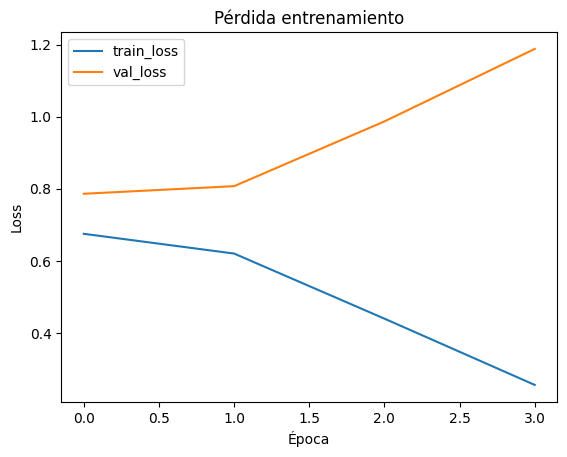

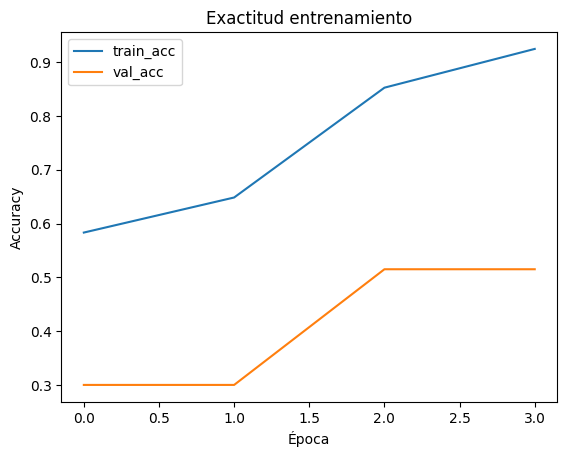

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


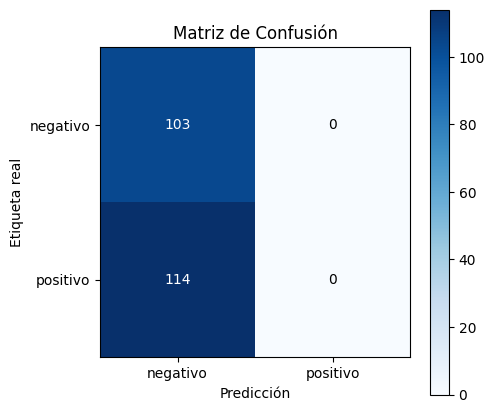

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negativo       0.47      1.00      0.64       103
    positivo       0.00      0.00      0.00       114

    accuracy                           0.47       217
   macro avg       0.24      0.50      0.32       217
weighted avg       0.23      0.47      0.31       217



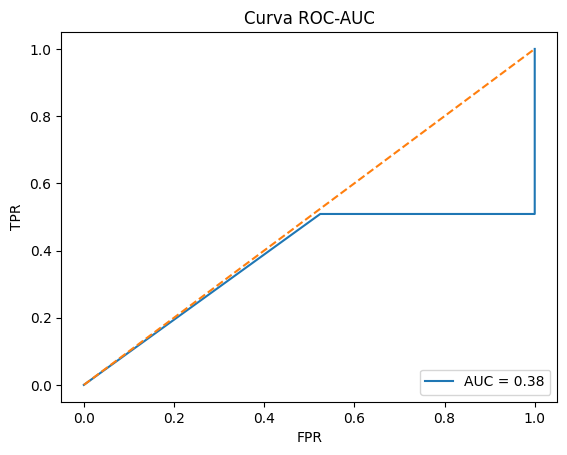

In [ ]:
# 7. Visualización de resultados
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Curvas
plt.figure()
plt.plot(historial.history['loss'], label='train_loss')
plt.plot(historial.history['val_loss'], label='val_loss')
plt.title('Pérdida entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(historial.history['accuracy'], label='train_acc')
plt.plot(historial.history['val_accuracy'], label='val_acc')
plt.title('Exactitud entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Matriz de confusión
y_prob = modelo.predict(X_pru_dl)
y_pred = (y_prob > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(y_pru_dl, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
ticks = [0,1]
plt.xticks(ticks, ['negativo','positivo'])
plt.yticks(ticks, ['negativo','positivo'])
for i in ticks:
    for j in ticks:
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.show()

# Reporte y ROC
print(classification_report(y_pru_dl, y_pred, target_names=['negativo','positivo']))
fpr, tpr, _ = roc_curve(y_pru_dl, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Curva ROC-AUC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()


## 8. Reflexión y Mejoras Futuras

**Desempeño Obtenido**  
- Baseline TF–IDF + LR: accuracy ≈ 0.48  
- Bi-LSTM desde cero (validación real): accuracy ≈  ~ 0.47/0.48 para “negativo” y ~ 0.52/0.51 para “positivo”
- ROC-AUC en test: ≈ 0.38

**Limitaciones Identificadas**  
- Validación interna corregida para evitar leakage.  
- Modelo todavía memorizando datos de validación interna si no se regula.  
- Pocos ejemplos únicos y alta repetición.

**Mejora Futuras**  
1. Incorporar embeddings pre-entrenados (FastText/GloVe).  
2. Probar Transformers (BETO) para mejorar semántica.  
3. Ajustar más la regularización y learning rate.  
4. Data augmentation para ampliar datos.
